# Day 11

In [1]:
class IntcodeComputer:
    def __init__(self, bits):
        self.bits = bits.copy() + [0]* 100_000
        self.i = 0
        self.outputs = []
        self.inputs = []
        self.input_i = 0
        self.relative_base = 0 
        self.state = 'Not Started'

        
    def _apply_mode(self, instruction, i):
        mode = int(instruction[-2-i])
        loc = self.i + i
        
        if mode == 0:
            return self.bits[self.bits[loc]]
        elif mode == 1:
            return self.bits[loc]
        elif mode ==2:
            return self.bits[self.relative_base + self.bits[loc]]
    
    def _write_mode(self, instruction, i, write):
        if instruction[-2-i] == '0':
            self.bits[self.bits[self.i+i]] = write
        else:
            self.bits[self.bits[self.i+i] + self.relative_base] = write
    
    def run(self, inputs=[]):
        if isinstance(inputs, list):
            self.inputs += inputs
        else:
            self.inputs += [inputs]

        while True:
            instruction = ("00000" + str(self.bits[self.i]))[-6:]
            opcode = int(instruction[-2:])
                        
            if opcode == 99:
                self.state = 'Finished'
                return int(self.outputs[-1])
            elif opcode == 1:
                p1 = self._apply_mode(instruction, 1)
                p2 = self._apply_mode(instruction, 2)
                
                self._write_mode(instruction, 3, p1+p2)
                self.i = self.i+4
            elif opcode == 2:
                p1 = self._apply_mode(instruction, 1)
                p2 = self._apply_mode(instruction, 2)
                
                self._write_mode(instruction, 3, p1*p2)
                self.i = self.i+4
            elif opcode == 3:
                if len(self.inputs) <= self.input_i:
                    self.state = 'Paused'
                    if len(self.outputs) > 0:
                        return int(self.outputs[-1])
                    else:
                        return None
                
                self._write_mode(instruction, 1, self.inputs[self.input_i])                
                self.input_i += 1
                self.i = self.i+2
            elif opcode == 4:
                output_val = self._apply_mode(instruction, 1)
                self.outputs += [output_val]
                self.i = self.i+2
            elif opcode == 5:
                p1 = self._apply_mode(instruction, 1)
                p2 = self._apply_mode(instruction, 2)

                if p1 > 0:
                    self.i = p2
                else:
                    self.i = self.i+3
            elif opcode == 6:
                p1 = self._apply_mode(instruction, 1)
                p2 = self._apply_mode(instruction, 2)

                if p1 == 0:
                    self.i = p2
                else:
                    self.i = self.i+3
            elif opcode == 7:
                p1 = self._apply_mode(instruction, 1)
                p2 = self._apply_mode(instruction, 2)
                p3 = self._apply_mode(instruction, 3)
                if p1 < p2:
                    self._write_mode(instruction, 3, 1)
                    #self.bits[self.bits[self.i+3]] = 1
                else:
                    self._write_mode(instruction, 3, 0)
                    #self.bits[self.bits[self.i+3]] = 0
                self.i = self.i+4
            elif opcode == 8:
                p1 = self._apply_mode(instruction, 1)
                p2 = self._apply_mode(instruction, 2)
                p3 = self._apply_mode(instruction, 3)
                if p1 == p2:
                    self._write_mode(instruction, 3, 1)
                    #self.bits[self.bits[self.i+3]] = 1
                else:
                    self._write_mode(instruction, 3, 0)
                    #self.bits[self.bits[self.i+3]] = 0
                self.i = self.i+4            
            elif opcode == 9:
                self.relative_base = self.relative_base + self._apply_mode(instruction, 1)
                self.i = self.i+2

In [2]:
from collections import defaultdict

In [3]:
class Robot():
    def __init__(self, intcode):
        self.brain = IntcodeComputer(intcode)
        self.facing = 0
        self.positions = [(0,0)] 
        self.colours = defaultdict(lambda : 0)
        
    def make_step(self):
        pos = self.positions[-1]
        col = self.colours[pos]
        self.brain.run(col)
        col, turn = self.brain.outputs[-2:]
        self.colours[pos] = col
        
        turn = 90 if turn == 1 else -90
        self.facing = (self.facing + turn) % 360
        
        if self.facing==0:
            dx, dy = (0,1)
        elif self.facing==90:
            dx, dy = (1,0)
        elif self.facing==180:
            dx, dy = (0,-1)
        else:
            dx, dy = (-1,0)
        
        x, y = pos
        self.positions += [(x+dx, y+dy)]
    
    def set_robot_off(self):
        while self.brain.state!='Finished':
            self.make_step()
            
    def make_grid(self):
        mins = np.array(self.positions).min(axis=0)
        maxs = np.array(self.positions).max(axis=0)
        center = np.array((2-mins[1], 2-mins[0], 0))
        
        grid = np.array([['.' for _ in range(mins[1]-2, maxs[1]+3)] for _ in range(mins[0]-2, maxs[0]+3)])
        
        for p in self.positions:
            pos = p+center
            grid[pos[0],pos[1]] = '#' if  p[2] == 1 else '.'
        
        if self.facing==0:
            grid[pos[0], pos[1]+1] = "^"
        elif self.facing==90:
            grid[pos[0]+1, pos[1]] = ">"
        elif self.facing==180:
            grid[pos[0], pos[1]-1] = "v"
        else:
            grid[pos[0]-1, pos[1]] = "<"
        
        return grid


In [4]:
with open('data/day11.txt') as fn:
    intcode = fn.readline().split(',')
    intcode = [int(b) for b in intcode]

# Q1

In [5]:
robot = Robot(intcode)
robot.set_robot_off()
len(robot.colours)

2336

# Q2

In [6]:
robot = Robot(intcode)
robot.colours[(0,0)] = 1
robot.set_robot_off()

In [7]:
import matplotlib.pyplot as plt

In [8]:
xrange, yrange = [[func([k[i] for k in robot.colours.keys()]) for func in [min, max]] for i in range(0,2)]

In [9]:
matrix = []
for y in range(yrange[1], yrange[0]-1,-1):
    row = []
    for x in range(xrange[0], xrange[1]+1):
        row.append(robot.colours[(x,y)])
    matrix.append(row)
        

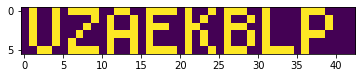

In [10]:
plt.imshow(matrix);